<a href="https://colab.research.google.com/github/its-Nhi-Ho/DS102__P.21/blob/master/BTTH5_Gausssian_Mixture_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

class GaussianMixtureModel:
    def __init__(self, n_components, max_iter=100, tol=1e-4, reg_covar=1e-6):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg_covar = reg_covar
        self.weights = None  # Trọng số hỗn hợp (pi_k)
        self.means = None    # Trung bình (mu_k)
        self.covariances = None # Ma trận hiệp phương sai (Sigma_k)
        self.log_likelihood_history = []

    def _multivariate_gaussian_pdf(self, X, mean, cov):
        n_features = X.shape[1]

        cov_for_cholesky = cov + np.eye(n_features) * self.reg_covar

        try:
            L = np.linalg.cholesky(cov_for_cholesky)
        except np.linalg.LinAlgError:
            print(f"Cảnh báo: Phân rã Cholesky thất bại. Ma trận hiệp phương sai có thể không xác định dương. Đang tăng giá trị regularization lên {self.reg_covar * 10}.")
            cov_for_cholesky = cov + np.eye(n_features) * (self.reg_covar * 10)
            try:
                L = np.linalg.cholesky(cov_for_cholesky)
            except np.linalg.LinAlgError:
                raise ValueError("Phân rã Cholesky thất bại ngay cả sau khi tăng regularization. Hãy kiểm tra dữ liệu hoặc ma trận hiệp phương sai ban đầu.")

        det_cov = np.prod(np.diagonal(L))**2

        X_centered = X - mean

        z = np.linalg.solve(L, X_centered.T).T

        exponent = -0.5 * np.sum(z**2, axis=1)

        norm_const = 1.0 / np.sqrt((2 * np.pi)**n_features * det_cov)

        return norm_const * np.exp(exponent)

    def _initialize_parameters(self, X):
        n_samples, n_features = X.shape

        # Khởi tạo trọng số hỗn hợp đồng đều
        self.weights = np.ones(self.n_components) / self.n_components

        # Khởi tạo trung bình bằng cách chọn ngẫu nhiên các điểm dữ liệu làm tâm
        random_indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[random_indices]

        # Khởi tạo ma trận hiệp phương sai là ma trận đơn vị
        self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])

    def _calculate_log_likelihood(self, X, responsibilities, sum_responsibilities_per_sample):
        # Tránh log(0) bằng cách thêm một lượng epsilon nhỏ
        return np.sum(np.log(sum_responsibilities_per_sample + 1e-300))


    def fit(self, X):
        n_samples, n_features = X.shape
        self._initialize_parameters(X)
        prev_log_likelihood = -np.inf

        print("Bắt đầu huấn luyện GMM (thuật toán EM)...")
        for iteration in range(self.max_iter):
            # E-step (Expectation)
            cluster_pdfs = np.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                cluster_pdfs[:, k] = self._multivariate_gaussian_pdf(X, self.means[k], self.covariances[k])

            weighted_pdfs = self.weights * cluster_pdfs
            sum_weighted_pdfs = np.sum(weighted_pdfs, axis=1, keepdims=True)
            responsibilities = weighted_pdfs / (sum_weighted_pdfs + 1e-300)

            # M-step (Maximization)
            N_k = np.sum(responsibilities, axis=0)

            for k in range(self.n_components):
                # Cập nhật trung bình
                self.means[k] = np.sum(responsibilities[:, k, np.newaxis] * X, axis=0) / (N_k[k] + 1e-300)

                # Cập nhật ma trận hiệp phương sai (sửa đổi theo cách của bạn)
                diff = X - self.means[k]
                # Trọng số của từng điểm dữ liệu cho cluster k
                weighted_diff = responsibilities[:, k][:, np.newaxis] * diff
                # Tính tổng có trọng số của outer product (x_n - mu_k)(x_n - mu_k)^T
                # weighted_diff.T có shape (n_features, n_samples)
                # diff có shape (n_samples, n_features)
                self.covariances[k] = (weighted_diff.T @ diff) / (N_k[k] + 1e-300)

                # Thêm regularization trực tiếp vào ma trận hiệp phương sai sau khi cập nhật
                self.covariances[k] += np.eye(n_features) * self.reg_covar

            self.weights = N_k / (n_samples + 1e-300)

            current_log_likelihood = self._calculate_log_likelihood(X, responsibilities, sum_weighted_pdfs)
            self.log_likelihood_history.append(current_log_likelihood)

            print(f"Lần lặp {iteration+1}/{self.max_iter}, Log-Likelihood: {current_log_likelihood:.4f}")

            if iteration > 0 and np.abs(current_log_likelihood - prev_log_likelihood) < self.tol:
                print(f"GMM đã hội tụ ở lần lặp {iteration+1}")
                break
            prev_log_likelihood = current_log_likelihood
        print("Quá trình huấn luyện GMM đã hoàn tất.")

    def predict_proba(self, X):
        n_samples = X.shape[0]
        cluster_pdfs = np.zeros((n_samples, self.n_components))
        for k in range(self.n_components):
            cluster_pdfs[:, k] = self._multivariate_gaussian_pdf(X, self.means[k], self.covariances[k])

        weighted_pdfs = self.weights * cluster_pdfs
        sum_weighted_pdfs = np.sum(weighted_pdfs, axis=1, keepdims=True)

        # Thêm epsilon để tránh chia cho 0
        return weighted_pdfs / (sum_weighted_pdfs + 1e-300)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [ ]:
import cv2
import matplotlib.pyplot as plt

def remove_background_with_gmm(image_path, n_components=2, display=True):
    # Đọc hình ảnh
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Không thể đọc hình ảnh từ {image_path}")

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pixels = img_rgb.reshape(-1, 3).astype(np.float32)

    gmm = GaussianMixtureModel(n_components=n_components)
    gmm.fit(pixels)

    labels = gmm.predict(pixels)

    foreground_mask = (labels != np.argmax(np.bincount(labels))).reshape(img.shape[:2]).astype(np.uint8)
    masked_img = cv2.bitwise_and(img, img, mask=foreground_mask)

    if display:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(img_rgb)
        plt.title("Hình ảnh gốc")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(foreground_mask, cmap="gray")
        plt.title("Mặt nạ tiền cảnh")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
        plt.title("Hình ảnh đã loại bỏ nền")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    return masked_img, labels

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cow.jpg to cow.jpg


In [ ]:
!pip install opencv-python

Bắt đầu huấn luyện GMM (thuật toán EM)...
Lần lặp 1/100, Log-Likelihood: -13936739.6684
Lần lặp 2/100, Log-Likelihood: -1182578.4223
Lần lặp 3/100, Log-Likelihood: -637708.5561
Lần lặp 4/100, Log-Likelihood: -616918.9028
Lần lặp 5/100, Log-Likelihood: -591515.7510
Lần lặp 6/100, Log-Likelihood: -574428.9621
Lần lặp 7/100, Log-Likelihood: -559439.6022
Lần lặp 8/100, Log-Likelihood: -547513.6140
Lần lặp 9/100, Log-Likelihood: -541011.8701
Lần lặp 10/100, Log-Likelihood: -538574.2574
Lần lặp 11/100, Log-Likelihood: -537724.1598
Lần lặp 12/100, Log-Likelihood: -537443.3865
Lần lặp 13/100, Log-Likelihood: -537363.2898
Lần lặp 14/100, Log-Likelihood: -537341.7597
Lần lặp 15/100, Log-Likelihood: -537336.0926
Lần lặp 16/100, Log-Likelihood: -537334.6229
Lần lặp 17/100, Log-Likelihood: -537334.2451
Lần lặp 18/100, Log-Likelihood: -537334.1493
Lần lặp 19/100, Log-Likelihood: -537334.1253
Lần lặp 20/100, Log-Likelihood: -537334.1185
Lần lặp 21/100, Log-Likelihood: -537334.1165
Lần lặp 22/100, Log

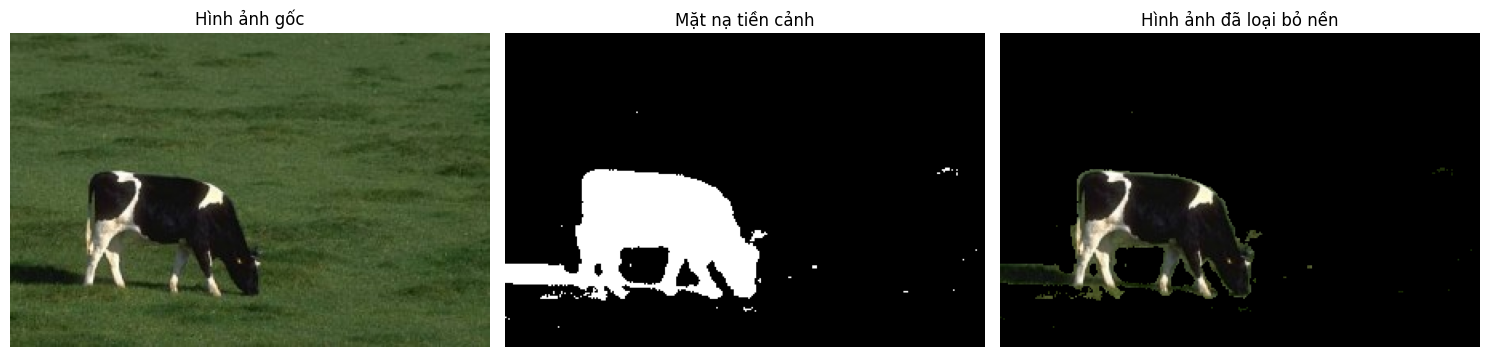

In [ ]:
# Sử dụng hàm
image_path = "/content/cow.jpg"
masked_image, predicted_labels = remove_background_with_gmm(image_path, display=True)

In [ ]:
# Lưu hình ảnh đã xử lý
cv2.imwrite("background_removed.jpg", masked_image)